## Production Code

When converting our code snippets into production-level code, we have a few goals,
1. **Readability**:	Our code should be easy to understand and follow, even for someone who didn’t write it. Clear naming conventions, well-structured functions, and comments where necessary help ensure that others can read and maintain the code effectively.


2.	**Robustness**: The code needs to handle different edge cases and potential errors gracefully, without breaking. This means writing code that checks for invalid inputs, unexpected conditions, and includes error handling to keep the program running smoothly.

3.	**Testing**: Code should be tested thoroughly to ensure it works as expected in various scenarios. This involves writing test cases that cover different functionalities, both common and rare, to catch bugs early and maintain confidence in the code’s reliability.

To achieve these goals, we need a solid design approach that provides structure and flexibility to our code. This is where Object-Oriented Programming (OOP) comes in. It's one of the most popular frameworks, and you've likely worked with it in class or otherwise. OOP offers a way to organize code into logical units that make it easier to read, robust, and testable. By structuring our code around objects that encapsulate data and functionality, we create a modular framework that simplifies complex data operations and supports future growth.

OOP promotes modularity, reusability, and maintainability, allowing for a clearer separation of concerns and reducing the likelihood of errors. Additionally, OOP’s use of abstraction and inheritance helps create reusable components, ensuring consistent and efficient code across all parts of the project. So, what does this all actually look like in practice?

Let's start with a general flow diagram

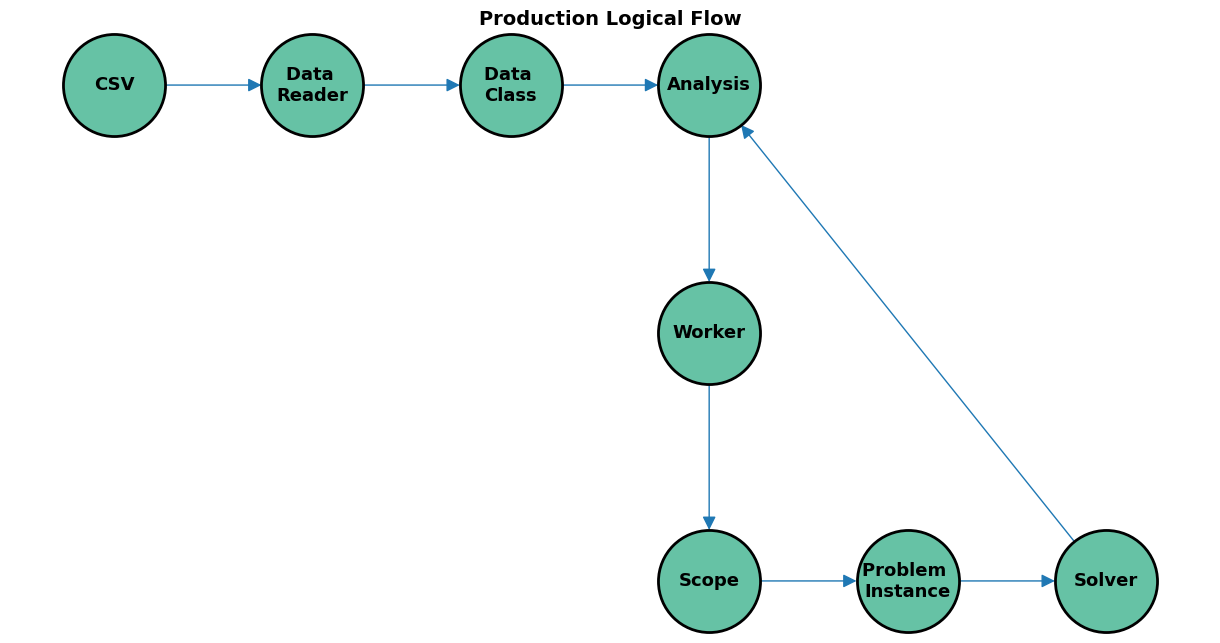

In [169]:
flowchart()

##### Data Reader and Class

The first stage in the process is obviously cleaning and processing the data, and one of the interesting things that you may not have seen in course-work is the segmentation of the data reader class and the dataset class. Often in smaller projects, the reader functionality is added as a class method, many times within the instantiation call, which can make intuitive sense. However, there are a few key benefits to separating them out when we work with larger projects.

1. Separation of Concerns: By creating separate classes, each class is responsible for a distinct function — the data reader class handles the loading and preprocessing of data from various sources, while the dataset class manages how the data is stored, accessed, and manipulated. This separation makes the codebase easier to understand and modify, as changes to how data is read do not impact how the data is organized or utilized downstream.


2.	Reusability: When data reading and data management are isolated into their own classes, they can be reused across different projects or tasks without modification. For instance, the same data reader class can be employed to load data from multiple sources (like CSVs, databases, or APIs) while reusing the dataset class to provide a uniform interface for accessing and manipulating data, regardless of its origin.
3.	Maintainability: Segmenting these responsibilities simplifies debugging and testing. If there is an issue with data loading, the problem is likely within the data reader class, whereas issues with data handling can be traced back to the dataset class. This modularity reduces the risk of unintended side effects when making changes or improvements, since each class operates independently.
4.	Flexibility: A segmented approach allows developers to quickly adapt to changes in data sources or formats without needing to rewrite core data handling logic. The data reader class can be updated to handle new data formats or sources, while the dataset class remains consistent in providing a structured interface for data access and manipulation.
5.  Testability: Perhaps one of the largest advantages is a layout that more easily lends itself to testing. If someone manually creates a test set, either class can be tested regardless of the other's state, and where the errors lie is often much easier to figure out

As you'll come to see, one of the core principles used to develop large projects like this is similar to the idea of a black box from machine learning. With multiple people working together, there is an emphasis on smoothly integrating everyone's work. So this approach can allow a potentially difficult task (loading and preparing the data) to be distributed among developers without requiring everyone to understand all the intricacies of each class

Let's see how this has been implemented!


In [170]:
import functools
from dataclasses import dataclass, field
from typing import Callable, Tuple


@dataclass(frozen=True)
class Country:
    id: str = field(hash=True)
    continent: str = field(repr=False)


@dataclass(frozen=True)
class Location:
    id: str = field(hash=True)
    address: str = field(repr=False)
    country: Country = field(repr=False)
    latitude: float = field(repr=False)
    longitude: float = field(repr=False)


@dataclass(frozen=True)
class DisasterType:
    id: str


@dataclass(frozen=True)
class DisasterImpact:
    id: str
    disaster: "Disaster" = field(repr=False)
    location: "DisasterLocation" = field(repr=False)
    sub_location_nr: int = field(repr=False)
    total_affected: int = field(repr=False)

    def __repr__(self):
        return self.id


@dataclass(frozen=True)
class DisasterLocation(Location):
    def __repr__(self):
        return self.id


@dataclass(frozen=True)
class Disaster:
    id: str
    type: DisasterType = field(repr=False)
    day: int = field(repr=False)
    month: int = field(repr=False)
    year: int = field(repr=False)
    impacted_locations: list[DisasterImpact] = field(hash=False, repr=False)


@dataclass(frozen=True)
class Depot(Location):
    pass


@dataclass(frozen=True)
class Item:
    id: str = field(hash=True)
    weight: float = field(repr=False)  # Metric tons
    volume: float = field(repr=False)  # Cubic metres


@dataclass(frozen=True)
class TransportMode:
    id: str = field(hash=True)
    distance_method: str
    big_m_cost_elim: float
    max_driving_time_cut_above_hrs: float


@dataclass(frozen=True)
class DistanceInfo:
    distance: float  # Kilometres
    time: float  # Hours
    cost_per_ton: float  # USD

DistanceMatrix = dict[Tuple[Location, Location, TransportMode], DistanceInfo]


The Dataset class encapsulates all data required for the analysis and optimization tasks. It includes lists of depots, disasters, and disaster_locations, and dictionaries for probabilities of disasters, inventory levels, and other critical data. The _zero_demand_threshold is a constant used internally to determine when demand should be considered negligible.

In [171]:
@dataclass(frozen=True)
class Dataset:
    depots: list[Depot]
    disasters: list[Disaster]
    disaster_locations: list[DisasterLocation]
    probabilities: dict[Disaster, float]
    items: list[Item]
    transport_modes: list[TransportMode]
    inventory: dict[Tuple[Depot, Item], int]
    inventory_scenarios: dict[str, dict[Tuple[Depot, Item], int]]
    distance: DistanceMatrix
    people_affected: dict[Tuple[DisasterImpact, Item], float]
    persons_per_item_general: dict[Tuple[DisasterImpact, Item], float]
    persons_per_item_monthly: dict[Tuple[DisasterImpact, Item], float]
    disaster_affected_totals: dict[str, int]

    _zero_demand_threshold = 1e6


    '''
    The take_disaster_subset method allows us to focus our analysis on a specific 
    subset of disasters by providing a predicate function that filters disasters 
    based on certain criteria (e.g., date range, disaster type). It recalculates 
    probabilities to ensure they sum up to 1 after filtering. Related data such as 
    locations, distances, and affected populations are also filtered to maintain 
    consistency. If no filtering occurs (i.e., all disasters are included), the method 
    returns the original dataset to avoid unnecessary duplication.
    '''

    def take_disaster_subset(self, predicate: Callable[[Disaster], bool]) -> "Dataset":
        """
        Generate a smaller dataset by only selecting a subset of the disasters with corresponding data
        """
        disasters = list(filter(predicate, self.disasters))

        if len(disasters) == len(self.disasters):
            return self

        total_probability = sum(self.probabilities[disaster] for disaster in disasters)
        probabilities = {
            disaster: self.probabilities[disaster] / total_probability
            for disaster in disasters
        }
        locations = [
            impact.location
            for disaster in disasters
            for impact in disaster.impacted_locations
        ]
        distance = {
            (source, destination, mode): cell
            for (source, destination, mode), cell in self.distance.items()
            if destination in locations
        }
        people_affected = {
            (location, item): value
            for (location, item), value in self.people_affected.items()
            if location in locations
        }
        persons_per_item_general = {
            (location, item): value
            for (location, item), value in self.persons_per_item_general.items()
            if location in locations
        }
        persons_per_item_monthly = {
            (location, item): value
            for (location, item), value in self.persons_per_item_monthly.items()
            if location in locations
        }
        return Dataset(
            self.depots,
            disasters,
            locations,
            probabilities,
            self.items,
            self.transport_modes,
            self.inventory,
            self.inventory_scenarios,
            distance,
            people_affected,
            persons_per_item_general,
            persons_per_item_monthly,
            self.disaster_affected_totals,
        )
    
    '''
    The take_inventory_scenario method enables us to switch between different 
    inventory configurations stored in inventory_scenarios. By specifying a filename 
    key, we retrieve the corresponding inventory data. If the requested inventory 
    is already in use, the method returns the current dataset. Otherwise, it creates 
    a new Dataset instance with the updated inventory, facilitating comparative 
    analysis of different supply scenarios.
    '''

    def take_inventory_scenario(self, filename: str):
        if filename not in self.inventory_scenarios:
            raise RuntimeError("Inventory scenario not found")
        inventory = self.inventory_scenarios[filename]
        if inventory == self.inventory:
            return self
        return Dataset(
            self.depots,
            self.disasters,
            self.disaster_locations,
            self.probabilities,
            self.items,
            self.transport_modes,
            inventory,
            self.inventory_scenarios,
            self.distance,
            self.people_affected,
            self.persons_per_item_general,
            self.persons_per_item_monthly,
            self.disaster_affected_totals,
        )
    '''
    The general_demand property calculates the overall demand for each 
    item at each impacted location using general beta values 
    (persons_per_item_general). The beta value represents how many people 
    can be served per item. We utilize the _calc_items_needed helper method 
    for calculations. The @functools.cached_property decorator ensures that 
    the result is computed once and cached, improving performance for repeated 
    access.

    
    '''
    @functools.cached_property
    def general_demand(self) -> dict[Tuple[DisasterImpact, Item], float]:
        general_demand = {
            (location, item): self._calc_items_needed(
                self.people_affected[location, item],
                self.persons_per_item_general[location, item],
            )
            for disaster in self.disasters
            for location in disaster.impacted_locations
            for item in self.items
        }

        return {key: value for key, value in general_demand.items() if value > 1e-1}


    '''
    Similarly, the monthly_demand property calculates demand on a monthly 
    basis using persons_per_item_monthly. This allows us to capture time-sensitive 
    demand variations, which are crucial in disaster response. The result is 
    cached, and we filter out values below 1e-3 to maintain computational efficiency.
    '''

    @functools.cached_property
    def monthly_demand(self) -> dict[Tuple[DisasterImpact, Item], float]:
        monthly_demand = {
            (location, item): self._calc_items_needed(
                self.people_affected[location, item],
                self.persons_per_item_monthly[location, item],
            )
            for disaster in self.disasters
            for location in disaster.impacted_locations
            for item in self.items
        }

        return {key: value for key, value in monthly_demand.items() if value > 1e-3}

    '''
    The _calc_items_needed helper method computes the number of items required 
    based on the number of people affected and the beta value. If beta is zero or 
    exceeds a predefined threshold (_zero_demand_threshold), indicating negligible 
    demand, the method returns zero. Otherwise, it divides people_affected by beta 
    to determine the required items. This calculation is fundamental for planning supply 
    quantities in logistics.
    '''
    
    def _calc_items_needed(
        self,
        people_affected: float,
        beta: float,
    ):
        if beta == 0 or beta >= self._zero_demand_threshold:
            return 0
        else:
            return people_affected / beta

##### Analysis 

If you recall from section 2.6, to solve for optimal allocations we have to consider several independent items, which requires solving the model for each version. This can get messy pretty quickly considering the complexity of the model and the dataset that it uses. So in the actual implementation, the developers created a class to handle this larger loop. It will set up the problem for a specific context, and then call a dedicated solver class. 

While we won't go into it here, this set up also lends itself nicely to leveraging multithreading. You'll notice that there is a sub-class in the code which creates "workers". These allow use to handle each problem independently and is a common set-up in python for multi-threading. Luckily for our sakes, the problem overall is fast enough to be solved on a single instance, so this hasn't been implemented fully in production code!

So let's take a look at how it all comes together.

Firsr we'll define our name space and methods used from the data reader class:

In [172]:
from enum import IntEnum
from multiprocessing import Pool
from os import getenv
from typing import Callable

import pandas as pd

from src.data import Dataset, Disaster, DisasterImpact, DistanceInfo, Item
from src.solving import (
    AllocationStrategy,
    CostMatrix,
    Problem,
    Solution,
    SolverParameters,
    StochasticSolver,
)

class SolverObjective(IntEnum):
    Cost = (0,)
    Time = (1,)
    Distance = 2

SolutionTags = tuple[SolverObjective, AllocationStrategy]


Now we'll get into the meat of it:

Here, AnalysisParameters is a configuration class that holds various parameters influencing the analysis process. These settings allow us to control aspects like which disasters to consider, the objectives to optimize for, and how to handle inventory and demand.

In [173]:
class AnalysisParameters:
    """

    Attributes
    ----------
    expand_depot_set
        Flag indicating whether inventory can be reallocated to depots that don't currently hold any stock
    care_about_month_demand
        Flag indicating whether we take month-by-month demand (True) or the general number (False)
    disaster_month
        Month from which to select disasters
    num_months_to_average
        Number of months to use for selecting disasters, when disasterMonth>=0
    optimization_objectives
        Set of objectives to use for running the optimization model
    comparison_objectives
        Set of objectives to use for comparing results
    allocation_strategies
        Which strategies to test for (re)allocation inventory to depots in the first stage
    min_year
        First year from which disasters should be taken into account
    max_year
        Last year from which disasters should be taken into account
    scale_demand
        Whether demand must be scaled to not exceed total available inventory or not


    """

    expand_depot_set: bool = False
    care_about_month_demand: bool = True
    disaster_month: int = -1
    num_months_to_average: int = 3
    optimization_objectives: list[SolverObjective] = [
        SolverObjective.Cost,
        SolverObjective.Time,
    ]
    comparison_objectives: list[SolverObjective] = list(SolverObjective)
    allocation_strategies: list[AllocationStrategy] = list(AllocationStrategy)
    min_year: int = 1900
    max_year: int = 2100
    scale_demand: bool = True

The Analysis class encapsulates all results and statistics from the optimization runs. It includes solutions for different objectives and strategies, along with computed metrics that help in evaluating and comparing these solutions.

In [174]:
class Analysis:
    """
    Analysis results for multiple optimization runs for a single dataset and item, using different objectives and allocation strategies.

    Attributes
    ----------
    parameters:
        Parameters used to construct the analysis
    dataset:
        Original dataset being analyzed
    item:
        Item for which the analysis was performed
    solutions:
        Dictionary of solutions for all solved problems
    solution_stats
        Index: objective, strategy
        Columns:
        - coveredDemandExcDummy
        - dualTotInv
        - totalCostIncDummy
        - totalCostExcDummy
        - totalDemand
        - fractionOfDisastersUsingDummy
        - averageUnitCost
        - demandFulfillmentFraction
    balance_metric
        Index: objective
        Columns: balanceMetric
    units_shipped
        Index: objective, strategy, mode
        Columns: unitsShipped, unitsShippedWeighted
    people_served_per_item
        Index: objective, strategy
        Columns: peopleServedPerItem
    cross_ompact
        Index: objective, strategy, other
        Columns: impact
    """

    parameters: AnalysisParameters
    dataset: Dataset
    item: Item
    solutions: dict[SolutionTags, Solution]
    solution_stats: pd.DataFrame
    balance_metric: pd.DataFrame
    units_shipped: pd.DataFrame
    people_served_per_item: pd.DataFrame
    cross_impact: pd.DataFrame

    def __init__(
        self,
        parameters: AnalysisParameters,
        dataset: Dataset,
        item: Item,
        solutions: dict[SolutionTags, Solution],
        solution_stats: pd.DataFrame,
        balance_metric: pd.DataFrame,
        units_shipped: pd.DataFrame,
        people_served_per_item: pd.DataFrame,
        cross_impact: pd.DataFrame,
    ):
        self.parameters = parameters
        self.dataset = dataset
        self.item = item
        self.solutions = solutions
        self.solution_stats = solution_stats
        self.balance_metric = balance_metric
        self.units_shipped = units_shipped
        self.people_served_per_item = people_served_per_item
        self.cross_impact = cross_impact



The AnalyzerWorker class performs the core computation. It runs optimization models for different objectives and strategies, processes the results, and computes various metrics for analysis. The _post_process method compiles these results into meaningful statistics.

In [175]:
class AnalyzerWorker:
    def __init__(self, parameters: AnalysisParameters):
        self.parameters = parameters
        self._solver = StochasticSolver()

    def run(self, dataset: Dataset, item: Item) -> Analysis:
        #a=len(str(dataset))
        dataset = self._filter_dataset(dataset)
        #print(len(str(dataset))!=a)
        probabilities = {
            disaster: 1 / len(dataset.disasters) for disaster in dataset.disasters
        }

        solutions: dict[SolutionTags, Solution] = {}

        # Construct cost matrices once
        cost_matrices = {
            objective: self._get_cost_matrix(dataset, item, objective)
            for objective in SolverObjective
        }

        # Construct inventory
        inventory = self._select_inventory(dataset, item)
        if sum(inventory.values()) == 0:
            return None

        # Construct demand
        demand = self._select_demand(dataset, item)

        # Solve models for all objectives and strategies
        for objective in self.parameters.optimization_objectives:
            for strategy in self.parameters.allocation_strategies:
                problem = Problem(
                    dataset.depots,
                    inventory,
                    demand,
                    dataset.disasters,
                    probabilities,
                    dataset.transport_modes,
                    cost_matrices[objective],
                )
                parameters = SolverParameters(strategy, self.parameters.scale_demand)
                tags = (objective, strategy)
                solutions[tags] = self._solver.solve(problem, parameters)

        return self._post_process(dataset, item, cost_matrices, solutions)

    def dispose(self):
        self._solver.dispose()

    def _select_inventory(self, dataset: Dataset, item: Item):
        return {
            depot: dataset.inventory.get((depot, item), 0)
            for depot in dataset.depots
            if self.parameters.expand_depot_set
            or dataset.inventory.get((depot, item), 0) > 0
        }

    def _filter_dataset(self, dataset: Dataset) -> Dataset:
        if self.parameters.disaster_month > -1:
            months = range(
                self.parameters.disaster_month,
                self.parameters.disaster_month
                + 1
                + self.parameters.num_months_to_average,
            )
            months = [(month - 1) % 12 + 1 for month in months]
            predicate: Callable[[Disaster], bool] = (
                lambda disaster: disaster.month in months
            )
            dataset = dataset.take_disaster_subset(predicate)

        dataset = dataset.take_disaster_subset(
            lambda disaster: disaster.year >= self.parameters.min_year
            and disaster.year <= self.parameters.max_year
        )

        return dataset

    def _select_demand(
        self, dataset: Dataset, item: Item
    ) -> dict[DisasterImpact, float]:
        source = (
            dataset.monthly_demand
            if self.parameters.care_about_month_demand
            else dataset.general_demand
        )
        return {
            location: source.get((location, item), 0)
            for disaster in dataset.disasters
            for location in disaster.impacted_locations
        }

    def _get_cost_matrix(
        self, dataset: Dataset, item: Item, objective: SolverObjective
    ) -> CostMatrix:
        return {
            key: self._get_cost_element(value, objective, item)
            for key, value in dataset.distance.items()
        }

    def _get_cost_element(
        self, cell: DistanceInfo, objective: SolverObjective, item: Item
    ):
        if objective == SolverObjective.Cost:
            return item.weight * cell.cost_per_ton
        elif objective == SolverObjective.Time:
            return cell.time
        elif objective == SolverObjective.Distance:
            return cell.distance
        else:
            raise RuntimeError(f"Undefined objective {objective}")

    def _post_process(
        self,
        dataset: Dataset,
        item: Item,
        costs: dict[SolverObjective, CostMatrix],
        solutions: dict[SolutionTags, Solution],
    ):
        beta_source = (
            dataset.persons_per_item_monthly
            if self.parameters.care_about_month_demand
            else dataset.persons_per_item_general
        )
        beta = {
            location.id: beta_source[location, item]
            for disaster in dataset.disasters
            for location in disaster.impacted_locations
        }

        solution_stats = pd.DataFrame.from_records(
            [
                {
                    "objective": objective,
                    "strategy": strategy,
                    "coveredDemandExcDummy": solution.covered_demand_exc_dummy,
                    "dualTotInv": solution.dual_total_inventory,
                    "totalCostIncDummy": solution.total_cost_inc_dummy,
                    "totalCostExcDummy": solution.total_cost_exc_dummy,
                    "totalDemand": solution.total_demand,
                    "fractionOfDisastersUsingDummy": solution.fraction_of_disasters_using_dummy,
                }
                for (objective, strategy), solution in solutions.items()
            ]
        ).set_index(["objective", "strategy"])

        df_flows = pd.DataFrame.from_records(
            [
                {
                    "objective": objective,
                    "strategy": strategy,
                    "disaster": disaster.id,
                    "depot": depot.id,
                    "impact": impact.id,
                    "location": impact.location.id,
                    "mode": mode.id,
                    "flow": value,
                    "distance": dataset.distance[depot, impact.location, mode].distance
                    if depot.id != "DUMMY"
                    else None,
                }
                for (objective, strategy), solution in solutions.items()
                for (disaster, depot, impact, mode), value in solution.flow.items()
            ]
        )

        # Average unit cost
        solution_stats["averageUnitCost"] = solution_stats["totalCostExcDummy"] / (
            solution_stats["coveredDemandExcDummy"] + 1e-7
        )

        # Demand fulfillment fraction
        solution_stats["demandFulfillmentFraction"] = solution_stats[
            "coveredDemandExcDummy"
        ] / (solution_stats["totalDemand"] + 1e-7)

        # Balance metric
        strategies = set(solution_stats.reset_index()["strategy"])
        pivoted = solution_stats.reset_index().pivot(
            index="objective", columns="strategy", values="totalCostExcDummy"
        )
        pivoted["balanceMetric"] = (
            pivoted[AllocationStrategy.MinimizeFixedInventory]
            / (pivoted[AllocationStrategy.MinimizeTwoStage] + 1e-7)
            if AllocationStrategy.MinimizeFixedInventory in strategies
            and AllocationStrategy.MinimizeTwoStage in strategies
            else None
        )
        balance_metric = pivoted

        df_probabilities = pd.DataFrame.from_dict(
            {
                disaster.id: dataset.probabilities[disaster]
                for disaster in dataset.disasters
            },
            columns=["probability"],
            orient="index",
        )

        # Units shipped
        df_flow_no_dummy = df_flows.join(df_probabilities, on="disaster")
        df_flow_no_dummy = df_flow_no_dummy[
            df_flow_no_dummy["depot"] != "DUMMY"
        ]  # TODO Replace hardcoded dummy ID
        temp = df_flow_no_dummy.copy()
        temp["unitsShipped"] = temp["probability"] * temp["flow"]
        temp["unitsShippedWeighted"] = temp["unitsShipped"] * temp["distance"]
        units_shipped = (
            temp.set_index(["objective", "strategy", "mode"])[
                ["unitsShipped", "unitsShippedWeighted"]
            ]
            .groupby(["objective", "strategy", "mode"])
            .sum()
        )

        # People served per item
        temp = df_flow_no_dummy.copy()
        temp["beta"] = temp["impact"].apply(lambda loc: beta[loc])
        temp["peopleServed"] = temp["probability"] * temp["beta"] * temp["flow"]
        people_served = (
            temp.set_index(["objective", "strategy"])["peopleServed"]
            .groupby(["objective", "strategy"])
            .sum()
        )
        people_served_per_item = pd.DataFrame(
            people_served / (solution_stats["coveredDemandExcDummy"] + 1e-7),
            columns=["peopleServedPerItem"],
        )

        # Impact of optimizing one objective on another objective
        impact = []
        for other in self.parameters.comparison_objectives:
            cost = {
                (depot.id, location.id, mode.id): value
                for (depot, location, mode), value in costs[other].items()
            }
            temp = df_flow_no_dummy.copy()
            if temp.empty:
                raise RuntimeError("Empty flow matrix encountered")
            temp["cost"] = temp.apply(
                lambda row: cost[row["depot"], row["location"], row["mode"]], axis=1
            )
            temp["other"] = other
            temp["impact"] = temp["cost"] * temp["probability"] * temp["flow"]
            impact.append(temp.reset_index())
        cross_impact = (
            pd.concat(impact)
            .groupby(["objective", "strategy", "other"])[["impact"]]
            .sum()
        )

        return Analysis(
            self.parameters,
            dataset,
            item,
            solutions,
            solution_stats,
            balance_metric,
            units_shipped,
            people_served_per_item,
            cross_impact,
        )


The Analyzer class manages the analysis workflow. It can run analysis for a single item or for all items across various inventory scenarios. It utilizes the AnalyzerWorker to perform the computations and collects the results.

In [176]:
class Analyzer:
    """
    Service responsible for performing optimization runs and analysis on the results
    """

    def __init__(self, parameters: AnalysisParameters):
        self.parameters = parameters

    def run(self, dataset: Dataset, item: Item) -> Analysis:
        worker = AnalyzerWorker(self.parameters)
        result = worker.run(dataset, item)
        worker.dispose()
        return result

    def run_all(self, dataset: Dataset) -> dict[tuple[str, Item], Analysis]:
        inventory_datasets = {
            filename: dataset.take_inventory_scenario(filename)
            for filename in dataset.inventory_scenarios
        }
        tasks = [
            (filename, inventory_dataset, item)
            for (filename, inventory_dataset) in inventory_datasets.items()
            for item in inventory_dataset.items
        ]

        return self._run_tasks(tasks)

    def _run_tasks(self, tasks: list[tuple[str, Dataset, Item]]):
        use_multi_processing = getenv("CI", "false") == "false"
        use_multi_processing = False
        if use_multi_processing:
            with Pool(
                initializer=_analysis_worker_init, initargs=[self.parameters]
            ) as pool:
                result: list[tuple[str, Analysis]] = pool.map(
                    _analysis_worker_call, tasks
                )
        else:
            worker = AnalyzerWorker(self.parameters)
            result = [
                (filename, worker.run(dataset, item))
                for (filename, dataset, item) in tasks
            ]
            worker.dispose()
        return {
            (filename, analysis.item): analysis
            for (filename, analysis) in result
            if analysis is not None
        }


These next two functiomns function initializes a global worker for use in multiprocessing scenarios and calls the run method of the global worker with the provided arguments.

In [177]:
def _analysis_worker_init(parameters):
    global worker
    worker = AnalyzerWorker(parameters)


def _analysis_worker_call(arg: tuple[Dataset, Item]) -> tuple[str, Analysis]:
    global worker
    (filename, dataset, item) = arg
    return (filename, worker.run(dataset, item))


#### Geting it ready for Optimization


Let's take a look at thow the data is formated to be used in our solver. First we will set the context of our problemn 

#### Solver
The loop

Why the Prevalent Use of Dictionaries vs Lists?
Dictionaries are often favored over lists in production code for several reasons:

-	Key-Value Pairs: Dictionaries provide a convenient way to store and retrieve data by keys rather than by index. This makes dictionaries especially useful for scenarios where data is logically organized by unique identifiers (e.g., JSON-like structures, configurations).
-	Readability and Maintainability: With dictionaries, code becomes more readable and self-explanatory. For example, user['name'] is more descriptive than user[0].
-	Flexibility in Data Manipulation: Unlike lists, dictionaries allow quick updates and deletions by key, improving flexibility when modifying data.
-	Performance: For lookups, inserts, and deletions, dictionaries (hash maps) often provide average O(1) time complexity, while lists require O(n) for searching or removing elements unless the position is already known.

In [178]:
from dataclasses import dataclass
from enum import IntEnum
from typing import Tuple, Union

import gurobipy as gp
from gurobipy import GRB, tupledict

from src.data import Depot, Disaster, DisasterImpact, Location, TransportMode


class AllocationStrategy(IntEnum):
    '''
    The AllocationStrategy enumeration defines different strategies for allocating inventory in 
    our optimization model

    MinimizeTwoStage: Allows inventory reallocation in both stages of the model.

    MinimizeFixedInventory: Keeps the inventory fixed as in the initial state.

    WorstDepot: Allocates all inventory to the worst-performing depot to test the model's robustness.
    '''
    MinimizeTwoStage = 0
    MinimizeFixedInventory = 1
    WorstDepot = 2

'''
The SolverParameters class holds configuration settings for the solver.
'''
@dataclass(frozen=True)
class SolverParameters:
    """
    Parameters that influence how the solver transforms the Problem into a mathematical model.

    Attributes
    ----------
    allocation_strategy
        If and how inventory can be reallocated
    scale_demand
        Whether demand should be scaled (down) to not exceed supply
    """

    allocation_strategy: AllocationStrategy = (
        AllocationStrategy.MinimizeFixedInventory,
    )
    scale_demand: bool = False

'''
We define a type alias CostMatrix for readability. It represents a dictionary mapping a 
tuple of (source location, target location, transport mode) to a cost value (e.g., transportation 
cost, time, or distance). This matrix is essential for the optimization model to calculate 
costs associated with moving goods from depots to disaster impact locations.
'''
CostMatrix = dict[Tuple[Location, Location, TransportMode], float]

In [179]:
@dataclass(frozen=True)
class Problem:
    '''
    The Problem class encapsulates all the data required to define an optimization problem:

    depots: A list of depots where inventory is stored.
    
    inventory: A dictionary mapping each depot to the quantity of inventory it holds.
    
    demand: A dictionary mapping each DisasterImpact location to its demand.
    
    disasters: A list of disasters being considered.
    
    probabilities: A dictionary mapping each disaster to its probability of occurrence.
    
    transport_modes: A list of available transport modes.
    
    cost: The CostMatrix containing cost information for transporting goods.*
    '''
    depots: list[Depot]
    inventory: dict[Depot, int]
    demand: dict[DisasterImpact, float]
    disasters: list[Disaster]
    probabilities: dict[Disaster, float]
    transport_modes: list[TransportMode]
    cost: CostMatrix

The Solution class stores the results obtained after solving a Problem with specific SolverParameters. It includes various metrics and variables that describe the performance and decisions made by the optimization model, such as total costs, demand coverage, dual variables, and optimal flows. The _dummy_depot is a special depot used internally to handle unmet demand in the model.

In [180]:
@dataclass(frozen=True)
class Solution:
    """
    Result of solving a single Problem with specific SolverParameters

    Attributes
    ----------
    total_cost_inc_dummy
        Total transportation cost including artificial cost for using the dummy node (myObj)
    total_cost_exc_dummy
        Total transportation cost from the real depots (myObjNoDum)
    total_demand
        Total demand in the input data (myWeightedDemand)
    covered_demand_exc_dummy
        Demand served from real depots, averaged over all scenarios (myWeightedDemandMetNoDum)
    fraction_of_disasters_using_dummy
        Fraction of disaster scenarios for which not enough real inventory is available (myFractionOfDisastersUsingDummy)
    duals_inventory_exc_dummy_plus_dummy_cost
        Adjusted dual variables for the inventory constraints (values are independent of dummy costs) (dualsInvNoDum_PlusDummyCost)
    duals_inventory_exc_dummy_unadjusted
        Original dual variables for the inventory constraints, aggregated over disaster scenarios (dualsInvNoDum_UnAdj)
    duals_inventory_exc_dummy_all
        All original dual variables for the inventory constraints (dualsInvNoDum_All)
    flow_exc_dummy
        Allocation of depot inventory to disaster locations in each scenario, excluding the dummy depot (myFlowNoDum)
    flow
        Allocation of depot inventory to disaster locations in each scenario (myFlow)
    optimal_inventory
        Optimal or fixed allocation of inventory to depots (myOptInvNoDum)
    dual_total_inventory
        Dual variable for the total inventory constraint (dualTotInv)
    """

    total_cost_inc_dummy: float
    total_cost_exc_dummy: float
    total_demand: float
    covered_demand_exc_dummy: float
    fraction_of_disasters_using_dummy: float
    duals_inventory_exc_dummy_plus_dummy_cost: dict[Depot, float]
    duals_inventory_exc_dummy_unadjusted: dict[Depot, float]
    duals_inventory_exc_dummy_all: dict[Tuple[Disaster, Depot], float]
    flow_exc_dummy: dict[Tuple[Disaster, Depot, DisasterImpact, TransportMode], float]
    flow: dict[Tuple[Disaster, Depot, DisasterImpact, TransportMode], float]
    optimal_inventory: dict[Depot, float]
    dual_total_inventory: float

    _dummy_depot: Depot


The StochasticSolver class encapsulates the logic for solving stochastic optimization problems. The class variables _threshold_cost_elim and _threshold_cost_dummy are large constants used to effectively eliminate certain arcs or penalize the use of the dummy depot in the optimization model. The constructor initializes a dummy location and creates a Gurobi environment with specific parameters (e.g., disabling output and setting single-threaded execution).

In [181]:
class StochasticSolver:
    _threshold_cost_elim: float = 1e9
    _threshold_cost_dummy: float = 1e9

    def __init__(self):
        self._dummy = Location("DUMMY", "", "", 0, 0)
        self._env = gp.Env(params={"OutputFlag": 0, "Threads": 1})
    '''
    The dispose method releases resources associated with the Gurobi environment. 
    It's important to call this method after solving problems to prevent resource 
    leaks, especially when solving multiple problems in a loop.
    '''
    def dispose(self):
        self._env.dispose()
        self._env = None

    '''
    In the solve method, we begin by preparing the data for the optimization model:
    
    We include both real depots and the dummy depot in our list of sources.
    
    Demand scaling is performed if specified in the parameters.
    
    We construct the list of possible arcs in the transportation network, filtering out those with 
    prohibitive costs unless they involve the dummy depot.
    
    We calculate the cost for each arc, adjusting for disaster probabilities to reflect the expected
    cost across scenarios.
    
    We initialize a Gurobi model named "StochLP" for solving the stochastic linear program
    '''

    def solve(self, problem: Problem, parameters: SolverParameters) -> Solution:
        sources = problem.depots + [self._dummy]

        demand = (
            self._scale_demand(problem) if parameters.scale_demand else problem.demand
        )

        '''
        The arcs represent the possible transportation routes from the supply sources (depots and a dummy depot)
        to the disaster-impacted locations for each disaster scenario and transport mode. Specifically, 
        each arc is a tuple (k, i, j, v) where:

        k i a disaster scenario from the list of disasters being considered.
        
        i is a source location, which can be a real depot or a special dummy depot used to model unmet demand.
        
        j is a disaster impact location, representing an area affected by disaster k where relief goods are needed.
        
        v is a transport mode, such as road, air, or sea transport.
        These arcs form the edges of the transportation network in the model. They define all feasible routes along 
        which relief items can be transported from depots to impacted locations under different disaster scenarios and transportation options.
        
        '''

        arcs = gp.tuplelist(
            [
                (k, i, j, v)
                for i in sources
                for k in problem.disasters
                for j in k.impacted_locations
                for v in problem.transport_modes
                if (
                    self._get_arc_cost(problem.cost, i, j, v)
                    < self._threshold_cost_elim
                )
                or (i == self._dummy)
            ]
        )

        arc_cost = {
            (k, i, j, v): self._get_arc_cost(problem.cost, i, j, v)
            * problem.probabilities[k]
            for (k, i, j, v) in arcs
        }

        model = gp.Model("StochLP", env=self._env)

        # First stage variable: Quantity to be allocated to each depot
        x: tupledict[Depot, gp.Var] = model.addVars(problem.depots, lb=0, name="x")

        # Second stage variable: Quantity transported from (real or dummy) depot to disaster locations using each mode of transport
        y: tupledict[
            Tuple[Disaster, Union[Depot, Location], DisasterImpact, TransportMode],
            gp.Var,
        ] = model.addVars(arcs, lb=0, obj=arc_cost, name="y")

        # Constraint: Total incoming arc flow must cover demand for each disaster location
        model.addConstrs(
            (
                y.sum(k, "*", j, "*") == demand[j]
                for k in problem.disasters
                for j in k.impacted_locations
            ),
            name="satisfyDemand",
        )

        # Constraint: Total outgoing arc flow must match initial or reallocated inventory
        inventory_balance: tupledict[
            Tuple[Disaster, Depot], gp.Constr
        ] = model.addConstrs(
            (
                y.sum(k, i, "*", "*") <= x[i]
                for k in problem.disasters
                for i in problem.depots
            ),
            name="satisfySupply",
        )

        # Constraint: Ensure inventory reallocation matches total existing inventory
        total_initial_inventory = sum(problem.inventory.values())
        match_total_inventory = model.addConstr(x.sum() == total_initial_inventory)

        '''
        We define a helper function fix_inventory_balance to fix the inventory variables (x) to specific values, 
        effectively turning them into constants in the model. Based on the allocation_strategy
        
        MinimizeFixedInventory: We fix the inventory variables to their initial values, preventing reallocation.
        
        WorstDepot: We iterate over all depots, allocating all inventory to each one individually to find the depot 
        that results in the worst (highest) objective value. We then fix the inventory allocation to that depot, 
        which is useful for stress-testing the model's performance under adverse conditions.
        '''
        def fix_inventory_balance(values: dict[Disaster, float]):
            for key, value in values.items():
                x[key].LB = x[key].UB = value

        if parameters.allocation_strategy == AllocationStrategy.MinimizeFixedInventory:
            fix_inventory_balance(problem.inventory)
        elif parameters.allocation_strategy == AllocationStrategy.WorstDepot:
            worst_depot = None
            worst_objective = -1e100
            for depot in problem.depots:
                centralized_inventory = {
                    other: total_initial_inventory if other == depot else 0
                    for other in problem.depots
                }
                fix_inventory_balance(centralized_inventory)
                model.optimize()
                if model.Status != GRB.Status.OPTIMAL:
                    raise RuntimeError("Could not solve model to optimality")
                if model.ObjVal > worst_objective:
                    worst_depot = depot
                    worst_objective = model.ObjVal
            centralized_inventory = {
                other: total_initial_inventory if other == worst_depot else 0
                for other in problem.depots
            }
            fix_inventory_balance(centralized_inventory)

        model.optimize()
        if model.Status != GRB.Status.OPTIMAL:
            raise RuntimeError("Could not solve model to optimality")

        # Total transport cost
        total_cost_inc_dummy = model.ObjVal
        dummy_cost = sum(
            var.X * var.Obj for var in y.select("*", self._dummy, "*", "*")
        )
        total_cost_exc_dummy = total_cost_inc_dummy - dummy_cost

        # Demand met without using the dummy node
        covered_demand_by_dummy = sum(
            y[k, i, j, v].X * problem.probabilities[k]
            for (k, i, j, v) in arcs.select("*", self._dummy, "*", "*")
        )
        total_demand = sum(
            local_demand * problem.probabilities[j.disaster]
            for (j, local_demand) in demand.items()
        )
        covered_demand_exc_dummy = total_demand - covered_demand_by_dummy

        # Flow in solution
        solution_y = {key: y[key].X for key in arcs}

        # Fraction of disaster scenarios in which the dummy supply is used
        fraction_of_disasters_using_dummy = len(
            [
                disaster
                for disaster in problem.disasters
                if sum(
                    solution_y[key]
                    for key in arcs.select(disaster, self._dummy, "*", "*")
                )
                > 0
            ]
        ) / len(problem.disasters)

        # Dual variables for the inventory balance constraints
        dual_correction = fraction_of_disasters_using_dummy * self._threshold_cost_dummy
        duals_inventory_exc_dummy_unadjusted = {
            i: sum(inventory_balance[k, i].Pi for k in problem.disasters)
            for i in problem.depots
        }
        duals_inventory_exc_dummy_plus_dummy_cost = {
            i: dual_correction + pi
            for (i, pi) in duals_inventory_exc_dummy_unadjusted.items()
        }
        duals_inventory_exc_dummy_all = {
            (k, i): constr.Pi for (k, i), constr in inventory_balance.items()
        }

        flow = {(k, i, j, v): var.X for (k, i, j, v), var in y.items() if var.X > 0}

        flow_exc_dummy = {
            (k, i, j, v): value
            for (k, i, j, v), value in flow.items()
            if i != self._dummy
        }

        optimal_inventory = {depot: var.X for depot, var in x.items()}

        dual_total_inventory = (
            match_total_inventory.Pi
            if parameters.allocation_strategy
            == AllocationStrategy.MinimizeFixedInventory
            else None
        )

        '''
        Finally, we package all the extracted metrics and variables into a Solution object and return it. This object 
        provides a comprehensive view of the optimization results, enabling further analysis or reporting.
        '''

        return Solution(
            total_cost_inc_dummy,
            total_cost_exc_dummy,
            total_demand,
            covered_demand_exc_dummy,
            fraction_of_disasters_using_dummy,
            duals_inventory_exc_dummy_plus_dummy_cost,
            duals_inventory_exc_dummy_unadjusted,
            duals_inventory_exc_dummy_all,
            flow_exc_dummy,
            flow,
            optimal_inventory,
            dual_total_inventory,
            self._dummy,
        )

    '''
    The _get_arc_cost method retrieves the cost of transporting goods from a source to a target using a specific transport mode. If the 
    source is the dummy depot, it returns a high dummy cost to penalize 
    its use. If there is no cost information available for a given arc 
    (i.e., cell is None), it returns a high elimination threshold cost 
    to effectively remove that arc from consideration.
    '''

    def _get_arc_cost(
        self,
        cost: CostMatrix,
        source: Location,
        target: DisasterImpact,
        mode: TransportMode,
    ):
        if source == self._dummy:
            return self._threshold_cost_dummy
        cell = cost.get((source, target.location, mode))
        return self._threshold_cost_elim if cell == None else cell

    '''
    The _scale_demand method adjusts the demand levels so that total demand 
    does not exceed total supply. For each disaster, it calculates a scaling 
    factor based on the ratio of total supply to total demand. It then applies 
    this factor to the demand at each impacted location. This is useful in scenarios 
    where supply constraints are tight, ensuring that the optimization model 
    operates within feasible limits.
    
    '''
    def _scale_demand(self, problem: Problem) -> dict[DisasterImpact, float]:
        supply = sum(problem.inventory.values())
        result: dict[DisasterImpact, float] = {}
        for disaster in problem.disasters:
            total_demand = sum(
                problem.demand[location] for location in disaster.impacted_locations
            )
            factor = min(1, supply / total_demand) if total_demand > 1e-6 else 1
            for location in disaster.impacted_locations:
                result[location] = factor * problem.demand[location]
        return result


After diving into the code, it's clear that it's exceptionally well-crafted, following best practices and maintaining high readability. The lead developer shared some key insights that contributed to this level of quality. These takeaways not only explain how the code reached its current state but also offer valuable lessons for future projects. Let's explore these insights to understand what makes the code stand out.

1. **Balancing Commenting on Different Projects with Different People Involved**

	When working on different projects involving different teams, it is crucial to adapt your commenting style to meet the team’s specific needs and coding standards. Here are some tips for balancing commenting styles across projects:

	- Understand Team Preferences: Some teams prefer more verbose comments to ensure all members understand the code, while others might lean towards minimal commenting to keep code clean. Spend time understanding each team’s culture and coding standards.

	
	- Project-specific Documentation: Tailor the level and style of commenting to fit the project’s needs. For example, a data science team might require detailed explanations of algorithms and mathematical steps, while a software engineering team may focus more on architectural and functional documentation.
	-	Reusable Templates: Create reusable templates or guidelines for comments that can be adapted easily for each project. For instance, standardize on docstring formats (e.g., Google-style, reStructuredText) and comment structures that can be tweaked as per the project’s requirements.
	-	Consistency is Key: Regardless of the project, maintain consistency in your commenting style within a single codebase. This reduces cognitive load and makes it easier for team members to understand the code quickly.
	-	Communicate Clearly: Have an open discussion with your teammates about their preferences. Clearly defined comment guidelines should be set and documented at the beginning of each project.

2. **Why the Prevalent Use of Dictionaries vs Lists?**
	In the provided code examples, dictionaries are extensively used over lists, and this choice offers several advantages:

	-	**Key-Value Access**: Dictionaries allow for fast retrieval of data using keys, which is essential when dealing with entities identified by unique attributes. For example, the Dataset class uses dictionaries like inventory, probabilities, and distance to map complex relationships between depots, disasters, and locations. 
		```python
		inventory: dict[Tuple[Depot, Item], int]
		DistanceMatrix: Dict[Tuple[Location, Location, TransportMode], DistanceInfo]
		```

	-   **Readability**: Using dictionaries makes the code more self-explanatory. Accessing ```inventory[(depot, item)]``` is clearer than using index-based access in a list, improving code readability.

	-	**Performance**: Dictionaries provide average O(1) time complexity for lookups, which is beneficial when working with large datasets, as is common in disaster logistics modeling.



3. **Testing and Debugging**

	Testing and debugging are crucial for ensuring the reliability of production code, especially in complex systems like our stochastic solver where very real world impacts can occur if bugs go un-noticed. We haven't shown them specifically here for brevity, however, let's take a look at how we change our code to accomidate them:

	-	**Error Handling**: In the StochasticSolver class, we include checks after optimization to ensure that the model has reached an optimal solution. If not, we raise a RuntimeError with a clear message. For example:

		```python
		model.optimize()
		if model.Status != GRB.Status.OPTIMAL:
			raise RuntimeError("Could not solve model to optimality")
		```
	-	**Modularity for Testing**: The code is organized into modular functions and methods, such as _get_arc_cost and _scale_demand, which makes unit testing more manageable. Each function can be tested independently to verify that it behaves as expected.

		-	**Unit Tests**: Write unit tests for every function or module to ensure that each part works as expected independently. Unit tests should be automated and run frequently to catch errors early.
		-	**Integration Tests**: Test interactions between different modules to catch integration-related issues. Use mocking or stubbing to isolate dependencies when needed.
	
		-	**Logging**: Make effective use of logging with different levels (DEBUG, INFO, WARNING, ERROR, CRITICAL). Logging provides a way to understand what the code was doing at the time an error occurred without having to run it in a debugging mode.



4. **Any Particular Naming Rules? Discuss with Others**

	Consistent and meaningful naming conventions are crucial for collaboration:

	-	**CamelCase vs. snake_case**: Choose a naming convention that fits the projectand stick with it throughout the codebase. In this case we have:
		- CamelCase for classes like ```DisasterImpact```, ```AnalyzerWorker```, and ```StochasticSolver```
		-	snake_case for variables and functions like ```total_cost_inc_dummy```, ```_filter_dataset```, and ```optimal_inventory``` ) 

	-	**Descriptive Names**: Use descriptive names that clearly indicate the purpose of a variable, function, or class. Avoid abbreviations unless they are standard and well-known.
	
	-	**Prefixed Naming**: When needed, prefix variables to indicate their type or usage (is_ for booleans, num_ for numbers, str_ for strings). This is more common in languages with weaker type systems.

	
	-	**Team Agreements**: Have a discussion with your team to establish a naming convention that everyone agrees on. Document these conventions in a style guide that is accessible to all team members.



5. **Error Handling**

	Proper error handling is vital to ensure robustness in production code:
	-	**Specific Exceptions**: The code raises specific exceptions with informative messages. For example, in the ```take_inventory_scenario``` method of the Dataset class, a RuntimeError is raised if an inventory scenario is not found
		```python
		if filename not in self.inventory_scenarios:
		raise RuntimeError("Inventory scenario not found")
		```
	-	**Fallback Mechanisms**: In the solver, when a solution is not optimal, the code doesn't proceed blindly but instead stops execution, which prevents cascading errors and makes debugging easier.
	-	**Validation Checks**: Before performing operations, the code often checks for potential issues, such as verifying that the total inventory is not zero before proceeding with the optimization.


6. **Global Variables**

	Global variables should generally be avoided in production code due to potential issues with maintainability and concurrency:
	-	**Encapsulation**:Encapsulate variables within classes or functions to limit their scope and prevent unintended modifications. Classes like ```AnalyzerWorker``` and ```StochasticSolver``` encapsulate their data and methods, preventing external interference.
	-	**Controlled Scope**: In multiprocessing scenarios, global variables are used judiciously. For instance, a global worker is initialized in the ```_analysis_worker_init``` function for use in worker processes, but its scope is limited and managed carefully.
		```python
		def _analysis_worker_init(parameters):
			global worker
			worker = AnalyzerWorker(parameters)

		```
	-	**Unintended Side Effects**: Global variables can lead to unexpected side effects, making the code harder to debug and maintain.
	-	**Thread Safety**: In multi-threaded applications, global variables can lead to race conditions if not handled properly.
	-	**Use Constants Judiciously**: If you must use global variables, restrict them to constants (immutable values) and use them sparingly.




7. **Typing**

	Strong typing adds robustness and clarity to production code:

	-	**Function Annotations**: Methods specify the types of their arguments and return values, which aids in understanding what kinds of data are expected.
		```python
		def _get_cost_element(
			self, cell: DistanceInfo, objective: SolverObjective, item: Item):
		```


	-	**Type Aliases**: Defining type aliases like CostMatrix and DistanceMatrix makes complex types more readable and maintainable.
		```python
		CostMatrix = dict[Tuple[Location, Location, TransportMode], float]
		```
	-	**Static Type Checking**: Using type hints allows tools like mypy to perform static type checking, catching potential type errors before runtime.



By following these principles, you can improve code quality, collaboration, and maintainability in a production environment, while also tailoring your practices to different projects and teams.

#### Runing it All

So what would runing all this look like? Lets take a look!

In [182]:
COUNTRY = "vanuatu_simple"

# Run optimization
reader = CsvProblemReader()
dataset = reader.read(DATA_DIR / COUNTRY)

parameters = AnalysisParameters()
analyzer = Analyzer(parameters)
result = analyzer.run_all(dataset)

exisiting_stock_df = calc_exisiting_stock_df(dataset, country=COUNTRY)


Now let's save the outputs

In [183]:
from pathlib import Path

WORKSPACE_DIR = Path.cwd().resolve()
DATA_DIR = WORKSPACE_DIR / "data"
TEST_DATA_DIR = WORKSPACE_DIR / "data" / "test_data"
DASHBOARD_OUTPUT_PATH = WORKSPACE_DIR / "dashboard_output"


priority_change_df = create_priority_change(result, country=COUNTRY)

all_duals_df = pd.DataFrame()
for key, value in result.items():
    scenario = get_scenario(key)

    if scenario != "actual":
        continue

    duals_df = calc_duals_by_warehouse(value)
    all_duals_df = pd.concat([all_duals_df, duals_df], ignore_index=True)



In [184]:
def create_metrics():
    ### ProvinceAssessDF dashboard file
    provinces_df = pd.read_csv(DATA_DIR / COUNTRY / "province_lookup.csv")
    provinces_df: pd.DataFrame = ProvinceLookupDF.validate(provinces_df)
    province_assess_df: pd.DataFrame = create_province_assess_df(
        all_duals_df,
        provinces_df,
        COUNTRY,
    )

    ### WhStockAssessDF dashboard file
    duals_df_copy = all_duals_df.copy()
    wh_stock_assess: pd.DataFrame = item_stock_assess(duals_df_copy, provinces_df, COUNTRY)


    ### Reallocation dashboard file
    reallocation_df, single_warehouse_df = reallocation_dashboard_files(
        wh_stock_assess.copy(),
        result,
        COUNTRY,
        wh_stock_assess=wh_stock_assess,
    )

    ### Disaster totals dashboard file
    dis_totals_df = create_disaster_totals(dataset, COUNTRY)


    ### Save dashboard files

    if not (DASHBOARD_OUTPUT_PATH / COUNTRY).exists():
        (DASHBOARD_OUTPUT_PATH / COUNTRY).mkdir(parents=True)

    exisiting_stock_df.to_csv(
        DASHBOARD_OUTPUT_PATH / COUNTRY / "exisiting_stock.csv",
        index=False,
    )

    priority_change_df = priority_change_df.loc[
        priority_change_df[BalMetricsDashboard.run_pct] == "actual"
    ]
    priority_change_df = priority_change_df.drop(columns=[BalMetricsDashboard.run_pct])
    priority_change_df.to_csv(
        DASHBOARD_OUTPUT_PATH / COUNTRY / "priority_change.csv",
        index=False,
    )

    province_assess_df = province_assess_df.drop(columns=[ProvinceAssessDF.time])
    province_assess_df.to_csv(
        DASHBOARD_OUTPUT_PATH / COUNTRY / "province_assess.csv",
        index=False,
    )

    dec_wh_stock_assess = wh_stock_assess.drop(columns=[ItemProvinceAssessDF.time_hms])
    dec_wh_stock_assess.to_csv(
        DASHBOARD_OUTPUT_PATH / COUNTRY / "wh_stock_assess_as_decimal.csv",
        index=False,
    )
    wh_stock_assess = wh_stock_assess.drop(columns=[ItemProvinceAssessDF.time_hms])
    wh_stock_assess.to_csv(
        DASHBOARD_OUTPUT_PATH / COUNTRY / "wh_stock_assess.csv",
        index=False,
    )

    reallocation_df.to_csv(
        DASHBOARD_OUTPUT_PATH / COUNTRY / "reallocation.csv",
        index=False,
    )
    single_warehouse_df.to_csv(
        DASHBOARD_OUTPUT_PATH / COUNTRY / "single_warehouse.csv",
        index=False,
    )

    dis_totals_df.to_csv(
        DASHBOARD_OUTPUT_PATH / COUNTRY / "disaster_totals.csv",
        index=False,
    )